In [1]:
using Distributions, Integrals, Random, Roots, StatsPlots

In [2]:
# define p_vec as e.g.
# [v2/v1 v3/v2 v4/v3 α1 α2 α3 α4 mu1 mu2 mu3 mu4 mus sg1 sg2 sg3 sg4 sgs]

function F(x, ρ, μ, σ, K)
    return sum([ρ[i] * cdf(truncated(Normal(μ[i], σ[i]), 0, 1), x) for i in 1:K])
end

function f(x, ρ, μ, σ, K)
    return sum([ρ[i] * pdf(truncated(Normal(μ[i], σ[i]), 0, 1), x) for i in 1:K])
end

function G(Fim1, Fx, αsum)
    return (Fim1 - Fx) / αsum
end

function κ(i, t, v_rel)
    return sum([-log(v_rel[j]) for j in t:i-1])
end

function fi(x, μ, σ)
    return pdf(truncated(Normal(μ, σ), 0, 1), x)
end

function q(i, t, Fx_vec, x_vec, ρ, μ, σ, α, v_rel, k, K)
    # Fx_vec = [F(x0)=1, F(x1), F(x2), F(x3), ..., F(xk-1)]
    # x_vec = [x0 = 1, x1, x2, x3, ..., xk = 0]
    # x_vec[s] = x_{s-1}, so the limits of integration are and must be offset by 1 below
    # TODO: can some integrals be cached as a speed-up? can some integrals be computed in parallel?
    return sum([(α[t]/sum(α[1:s])) * solve(IntegralProblem{false}((x, p) -> exp(-(G(Fx_vec[s], F(x, ρ, μ, σ, K), sum(α[1:s])) + κ(s, t, v_rel))) * fi(x, μ[i], σ[i]), x_vec[s+1], x_vec[s]), HCubatureJL())[1] for s in t:k])
end

function Fx(t, α, v_rel)
    return 1 - sum([-log(v_rel[j])*sum(α[1:j]) for j in 1:t])
end

function Q2(ratio, β)
    return β * (1 - exp(-ratio)) / ratio
end

function pi(t, α)
    return α[t] / sum(α[1:t])
end

pi (generic function with 1 method)

In [3]:
"""
computes the distribution of placement outcomes according to the following specification:

    v_rel: vector of relative values v2/v1, v3/v2, v4/v3, ...
    α: vector of graduate-department ratio constants α_i
    μ: vector of μ parameters for the offer distributions
    σ: vector of σ parameters for the offer distributions
    ρ: vector of ratios for number of departments per tier
    β: match friction for second round
    k: number of graduating tiers
    K: number of hiring tiers
    M: number of placement outcomes to simulate

"""
function get_outcome_distribution(v_rel, α, μ, σ, ρ, β, k, K)
    Fx_vec = ones(k) # sets F(x0) = 1 by default; Fx_vec = [F(x0)=1, F(x1), F(x2), F(x3), ..., F(xk-1)]
    x_vec = ones(k+1) # x_vec = [x0 = 1, x1, x2, x3, ..., xk = 0]
    x_vec[k+1] = 0.0
    for t in 1:k-1
        Fx_vec_candidate = Fx(t, α, v_rel)
        if Fx_vec_candidate <= 0.0
            Fx_vec[t+1:k] .= 0.0
            x_vec[t+1:k] .= 0.0
            break
        end
        Fx_vec[t+1] = Fx_vec_candidate
        # there is no simple closed-form for F^{-1}(x) so this numerically computes x1, x2, x3
        x_vec[t+1] = find_zero(x -> F(x, ρ, μ, σ, K) - Fx_vec[t+1], 0.5) 
    end

    normalizer = 0.0
    q_it = zeros(K, k)
    for i in 1:K
        for t in 1:k
            prob = q(i, t, Fx_vec, x_vec, ρ, μ, σ, α, v_rel, k, K)
            q_it[i, t] = prob
            normalizer += ρ[i] * prob
        end
    end

    round_2 = zeros(K, k)
    D = sum([ρ[i] * (1 - sum([q_it[i, t] for t in 1:k])) for i in 1:K])
    S = sum([α[t] * (1 - sum([ρ[i]*q_it[i, t] for i in 1:K])) for t in 1:k])
    for i in 1:K
        for t in 1:k
            prob = (1 - sum([q_it[i, s] for s in 1:k])) * Q2(D/S, β) * α[t] * (1 - sum([ρ[j] * q_it[j, t] for j in 1:K])) / S
            round_2[i, t] = prob
            normalizer += ρ[i] * prob
        end
    end

    total = zeros(K*k)
    counter = 1
    for i in 1:K
        for t in 1:k
            total[counter] = (ρ[i] * (q_it[i, t] + round_2[i, t]) / normalizer)
            counter += 1
        end
    end

    return total
end

get_outcome_distribution

In [64]:
Random.seed!(0) # for reproducibility

num_graduates = 4
num_departments = 4

v_rel = zeros(num_graduates-1)
v_base = range(1, 0.3, num_graduates)
for i in 1:num_graduates-1
    v_rel[i] = v_base[i+1] / v_base[i]
end

α = [0.4, 0.3, 0.2, 0.1]#ones(num_graduates) / num_graduates
μ = range(0.25, 0.75, num_departments)
σ = 0.1 * ones(num_departments)
ρ = ones(num_departments) / num_departments
β = 0.0

0.0

In [65]:
outcome_distribution = get_outcome_distribution(v_rel, α, μ, σ, ρ, β, num_graduates, num_departments)

16-element Vector{Float64}:
 0.05593078436066111
 0.054714872826141646
 0.05239719499055985
 0.01756798814531303
 0.07565183424393107
 0.07395109369226735
 0.06587200954561875
 0.0014868161754499794
 0.11949061331241428
 0.10749042434323723
 0.04353650182102231
 1.1316080827433701e-5
 0.23713685399765627
 0.08970214955242375
 0.005059540558103435
 6.354372418347491e-9

In [71]:
placements = zeros(num_departments, num_graduates)
M = 10000
sample = rand(Multinomial(M, outcome_distribution))
counter = 1
for i in 1:num_departments
    for t in 1:num_graduates
        placements[i, t] = sample[counter]
        counter += 1
    end
end

In [72]:
placements

4×4 Matrix{Float64}:
  566.0   576.0  576.0  160.0
  735.0   725.0  633.0   19.0
 1154.0  1080.0  430.0    0.0
 2394.0   910.0   42.0    0.0

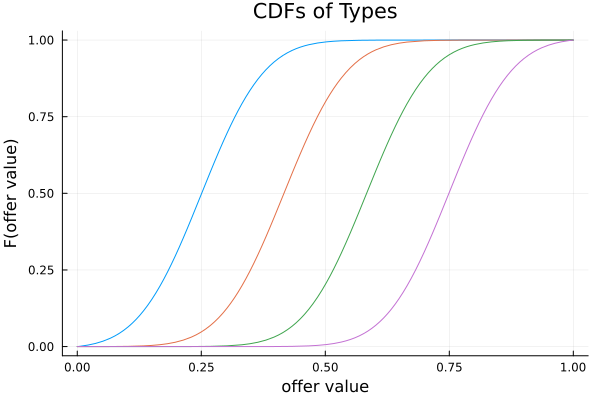

In [73]:
select_type = 1
cdfs = plot(truncated(Normal(μ[select_type], σ[select_type]), 0, 1), func = cdf, title = "CDFs of Types", legend = nothing)
for select_type in 2:num_departments # academic types
    plot!(cdfs, truncated(Normal(μ[select_type], σ[select_type]), 0, 1), func = cdf)
end

xlabel!(cdfs, "offer value")
ylabel!(cdfs, "F(offer value)")
cdfs

In [69]:
function print_metrics_maximum_likelihood(v_rel, α, μ, σ, ρ, β, placements, k, K, M)
    Fx_vec = ones(k)
    x_vec = ones(k+1)
    x_vec[k+1] = 0.0
    for t in 1:k-1
        Fx_vec_candidate = Fx(t, α, v_rel)
        if Fx_vec_candidate <= 0.0
            Fx_vec[t+1:k] .= 0.0
            x_vec[t+1:k] .= 0.0
            break
        end
        Fx_vec[t+1] = Fx_vec_candidate
        x_vec[t+1] = find_zero(x -> F(x, ρ, μ, σ, K) - Fx_vec[t+1], 0.5) 
    end

    objective = 0.0
    likelihood = 0.0
    normalizer = 0.0
    
    q_it = zeros(K, k)
    for i in 1:K, t in 1:k
        prob = q(i, t, Fx_vec, x_vec, ρ, μ, σ, α, v_rel, k, K)
        q_it[i, t] = prob
        normalizer += ρ[i] * prob
    end
    
    # TODO: div by zero and negative floating point in mean
    D = sum([ρ[i] * (1 - sum([q_it[i, t] for t in 1:k])) for i in 1:K])
    S = sum([α[t] * (1 - sum([ρ[i]*q_it[i, t] for i in 1:K])) for t in 1:k])
    round_2 = zeros(K, k)
    round_2_hiring = zeros(K, k)

    for i in 1:K, t in 1:k
        prob = (1 - sum([q_it[i, s] for s in 1:k])) * Q2(D/S, β) * α[t] * (1 - sum([ρ[j] * q_it[j, t] for j in 1:K])) / S
        round_2[i, t] = prob
        round_2_hiring[i, t] = Q2(D/S, β) * α[t] * (1 - sum([ρ[j] * q_it[j, t] for j in 1:K])) / S
        normalizer += ρ[i] * prob
    end

    round_1_failure = zeros(K)
    for i in 1:K
        round_1_failure[i] = (1 - sum([q_it[i, s] for s in 1:k]))
    end
    
    exp_placements_round_1 = zeros(K, k)
    exp_placements_round_2 = zeros(K, k)
    exp_placements = zeros(K, k)
    for i in 1:K, t in 1:k 
        expectation = M * (ρ[i] * (q_it[i, t] + round_2[i, t]) / normalizer)
        exp_placements_round_1[i, t] = M * (ρ[i] * q_it[i, t] / normalizer)
        exp_placements_round_2[i, t] = M * (ρ[i] * round_2[i, t] / normalizer)
        exp_placements[i, t] = expectation
        objective += (placements[i, t] - expectation) ^ 2 / expectation
        likelihood += placements[i, t] * (log(ρ[i] * (q_it[i, t] + round_2[i, t])))
        likelihood -= log(factorial(big(placements[i, t])))
    end
    likelihood -= M * log(normalizer)

    println("chi-square objective value = ", objective)
    println("log-likelihood objective value = ", likelihood)
    println("likelihood objective value = ", exp(likelihood))
    println("success sample size (departments) = ", M)
    println("estimated total samples (departments) = ", M / normalizer)
    println("estimated unmatched departments = ", (M / normalizer) - M)
    println("probability of any success: ", normalizer)
    println("probability of no success: ", 1 - normalizer)
    println("measure of departments in round 2 = ", D)
    println("measure of graduates in round 2 = ", S)
    println()
    println("predicted fraction of departments of each tier:")
    display(ρ)
    println()
    println("fractions observed among successful departments in data:")
    display(sum(placements, dims = 2) ./ M)
    println()

    for i in 1:k
        println("pi_", i, " = ", pi(i, α))
    end
    println()

    offer_targets = zeros(k, k)
    for t in 1:k, j in 1:t
        offer_targets[t, j] = pi(j, α) * prod([1 - pi(i, α) for i in j+1:t])
    end
    println("Tier selection probabilities for making offers:")
    display(offer_targets)
    println()

    println("Round 1 hiring probabilities:")
    display(q_it)
    println()

    println("Probabilities of failing round 1")
    display(round_1_failure)
    println()

    println("Probabilities of failing round 1 and hiring in round 2:")
    display(round_2)
    println()

    println("Round 2 hiring probabilities:")
    display(round_2_hiring)
    println()

    for i in 1:k+1
        println("x_", i - 1, " = ", x_vec[i])
    end
    println()
    for i in 1:k
        println("F(x_", i - 1, ") = ", Fx_vec[i])
    end
    println()
    for i in 1:k
        println("α_", i, " = ", α[i])
        println("  Est. graduates: ", α[i] * (M / normalizer - 1))
        println("  Successful: ", sum(placements[:, i]))
        println("  Unsuccessful: ", (α[i] * (M / normalizer - 1)) - sum(placements[:, i]))
    end
    println("Total estimated graduates: ", sum(α) * (M / normalizer - 1))
    println("Total successful graduates: ", M)
    println("Total estimated unsuccessful graduates: ", (sum(α) * (M / normalizer - 1)) - M)
    println("β = ", β)
    println()
    println("estimated placement rates, round 1 only:")
    display(exp_placements_round_1)
    println()
    println("estimated placement rates, round 2 only:")
    display(exp_placements_round_2)
    println()
    println("estimated placement rates, cumulative:")
    display(exp_placements)
    println()
    println("actual placement rates:")
    display(placements)
    println()
    println("difference between estimated and actual placement rates:")
    display(exp_placements - placements)
    println()
    println("chi-square p-value")
    println(1 - cdf(Chisq((size(placements)[1] - 1) * (size(placements)[2] - 1)), objective))
end

print_metrics_maximum_likelihood (generic function with 1 method)

In [76]:
print_metrics_maximum_likelihood(v_rel, α, μ, σ, ρ, β, placements, num_graduates, num_departments, M)

for i in 1:num_graduates-1
    println("v_", i + 1, "/v_", i, " = ", v_rel[i])
end

for i in 1:num_graduates
    println("v", i, ": ", v_base[i])
end

for select_type in 1:num_departments
    println("mean for type ", select_type, ": ", mean(truncated(Normal(μ[select_type], σ[select_type]), 0, 1)))
    println("stddev for type ", select_type, ": ", std(truncated(Normal(μ[select_type], σ[select_type]), 0, 1)))
    println()
end

4-element Vector{Float64}:
 0.25
 0.25
 0.25
 0.25

4×1 Matrix{Float64}:
 0.1878
 0.2112
 0.2664
 0.3346

4×4 Matrix{Float64}:
 1.0       0.0       0.0       0.0
 0.571429  0.428571  0.0       0.0
 0.444444  0.333333  0.222222  0.0
 0.4       0.3       0.2       0.1

4×4 Matrix{Float64}:
 0.134619  0.131693  0.126114   0.0422842
 0.182086  0.177992  0.158547   0.0035786
 0.287601  0.258718  0.104788   2.72366e-5
 0.570762  0.215903  0.0121778  1.52943e-8

4-element Vector{Float64}:
 0.5652895317998161
 0.4777968734026079
 0.34886673883496433
 0.20115661934370754

4×4 Matrix{Float64}:
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0

4×4 Matrix{Float64}:
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0

4×4 Matrix{Float64}:
  559.308   547.149  523.972   175.68
  756.518   739.511  658.72     14.8682
 1194.91   1074.9    435.365     0.113161
 2371.37    897.021   50.5954    6.35437e-5

4×4 Matrix{Float64}:
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0

4×4 Matrix{Float64}:
  559.308   547.149  523.972   175.68
  756.518   739.511  658.72     14.8682
 1194.91   1074.9    435.365     0.113161
 2371.37    897.021   50.5954    6.35437e-5

4×4 Matrix{Float64}:
  566.0   576.0  576.0  160.0
  735.0   725.0  633.0   19.0
 1154.0  1080.0  430.0    0.0
 2394.0   910.0   42.0    0.0

4×4 Matrix{Float64}:
  -6.69216  -28.8513   -52.0281   15.6799
  21.5183    14.5109    25.7201   -4.13184
  40.9061    -5.09576    5.36502   0.113161
 -22.6315   -12.9785     8.59541   6.35437e-5

chi-square objective value = 14.68417962168456
log-likelihood objective value = -82166.18840570367036959388653689802509163940831357662471514848789191299511771753
likelihood objective value = 4.761857336356147731308699814475983716511909335534749365140483596798988074998321e-35685
success sample size (departments) = 10000
estimated total samples (departments) = 16618.954778839554
estimated unmatched departments = 6618.954778839554
probability of any success: 0.601722559154726
probability of no success: 0.39827744084527394
measure of departments in round 2 = 0.39827744084527394
measure of graduates in round 2 = 0.8024416920811497

predicted fraction of departments of each tier:

fractions observed among successful departments in data:

pi_1 = 1.0
pi_2 = 0.4285714285714286
pi_3 = 0.22222222222222227
pi_4 = 0.10000000000000002

Tier selection probabilities for making offers:

Round 1 hiring probabilities:

Probabilities of failing round 1

Probabilities of failing round 1 and hiring in round

0.3
mean for type 1: 0.2517637825486672
stddev for type 1: 0.09775450595205172

mean for type 2: 0.41667344144355745
stddev for type 2: 0.09998587651041925

mean for type 3: 0.5833265585564426
stddev for type 3: 0.09998587651041925

mean for type 4: 0.7482362174513327
stddev for type 4: 0.09775450595205172

